# DVAA opto-constriction dataset analysis

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from logger import logger
from io_utils import load_stack_and_masks 
from viewers import view_stack
from correctors import LinRegCorrector, correct_stack
from plotters import *
from postpro import *

### Inputs

In [3]:
# Data root
dataroot = '/Users/tlemaire/Documents/data/hemo2p/DVAA datasets'

# Figures directory & dictionary
figsdir = os.path.join(dataroot, 'figs')
figs = {}

# Data directory 
datadir = os.path.join(dataroot, 'opto_constrict')
# datadir = os.path.join(dataroot, 'examples')
logger.info(f'input data directory: {datadir}')

# Define recording parameters
fps = 1 / 0.77764  # frames per second
fps = 1
umperpx = 1.29  # µm/pixel
logger.info(f'fps: {fps:.2f} Hz, spatial resolution: {umperpx} µm/px')

# Initialize family of LinRegCorrector variants
correctors = {}
robusts = [False] #, True]
intercepts = [True, False] 
for robust in robusts:
    for intercept in intercepts:
        lrc = LinRegCorrector(robust=robust, intercept=intercept)
        correctors[lrc.code] = lrc
correctors_str = '\n'.join([f'    - {k}: {v}' for k, v in correctors.items()])
logger.info(f'initialized the following correctors:\n{correctors_str}')

 2025/12/01 20:23:46: input data directory: /Users/tlemaire/Documents/data/hemo2p/DVAA datasets/opto_constrict
 2025/12/01 20:23:46: fps: 1.00 Hz, spatial resolution: 1.29 µm/px
 2025/12/01 20:23:46: initialized the following correctors:
    - linreg: LinRegCorrector(robust=False)
    - linreg_nointercept: LinRegCorrector(robust=False, no intercept)


### Load original stack data and ROI masks 

 2025/12/01 20:23:46: run data directory: /Users/tlemaire/Documents/data/hemo2p/DVAA datasets/opto_constrict/m028-009
 2025/12/01 20:23:46: input data directory: /Users/tlemaire/Documents/data/hemo2p/DVAA datasets/opto_constrict/m028-009
 2025/12/01 20:23:46: listing TIF files...
 2025/12/01 20:23:46: loading stack...
 2025/12/01 20:23:46: loaded 834-frames stack with shape 512x512
 2025/12/01 20:23:46: loaded 212 ROIs mask
 2025/12/01 20:23:46: run data directory: /Users/tlemaire/Documents/data/hemo2p/DVAA datasets/opto_constrict/m238-008
 2025/12/01 20:23:46: input data directory: /Users/tlemaire/Documents/data/hemo2p/DVAA datasets/opto_constrict/m238-008
 2025/12/01 20:23:46: listing TIF files...
 2025/12/01 20:23:46: loading stack...
 2025/12/01 20:23:47: loaded 601-frames stack with shape 512x512
 2025/12/01 20:23:47: loaded 360 ROIs mask
 2025/12/01 20:23:47: run data directory: /Users/tlemaire/Documents/data/hemo2p/DVAA datasets/opto_constrict/m292-004
 2025/12/01 20:23:47: inpu

Text(0.5, 0.98, 'mean FOVs with ROI contours')

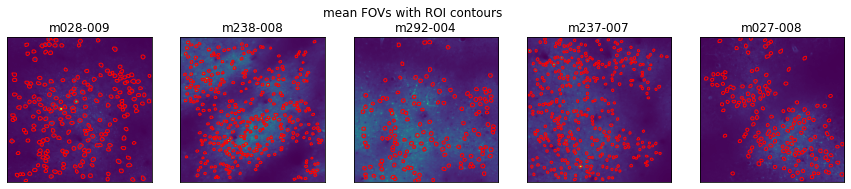

In [4]:
# List runs from sub-directories
runs = [k for k in os.listdir(datadir) if k != '.DS_Store']

# Loop through runs
stacks_per_run, masks_per_run = {}, {}
nframes_min = np.inf
for run in runs:
    rundir = os.path.join(datadir, run)
    logger.info(f'run data directory: {rundir}')

    # Load stack and associated masks
    stacks_per_run[run], masks_per_run[run] = load_stack_and_masks(rundir)
    nframes, *_ = stacks_per_run[run].shape
    if nframes < nframes_min:
        nframes_min = nframes

# Plot stack projection FOV and ROI contours
naxes = len(runs)
figtitle = 'mean FOVs with ROI contours' 
figs[figtitle], axes = plt.subplots(1, naxes, figsize=(naxes * 3, 3))
figs[figtitle].patch.set_facecolor('w')
for ax, run in zip(axes, runs):
    plot_FOV_and_masks(stacks_per_run[run], masks_per_run[run], ax=ax, title=run)
figs[figtitle].suptitle(figtitle)

### Define frame intervals for pre, stim, and post windows

In [5]:
# Define stimulus parameters
istims = np.arange(301, 403 + 1, 3)  # stimulus: 100 ms pulses every 3 frames from frame 301 to 403 included 
istimbounds = (istims[0], istims[-1])  # indexes of frames bounding the stimulus interval 

# Define inclusive (start, end) bounds for each analysis window 
windowsdict = {
    'pre': (0, istimbounds[0] - 1),
    'stim': istimbounds,
    'post': (istimbounds[-1] + 1, nframes_min - 1) 
}
windowstr = '\n'.join([f'   - {k}: {v[0]} - {v[1]}'for k, v in windowsdict.items()])
logger.info(f'frame bounds for analysis windows:\n{windowstr}')

# Define frames index list for each analysis window
framesdict = {k: np.arange(v[0], v[1] + 1) for k, v in windowsdict.items()}

# Concatenate pre and post frames indexes into a 'nostim' interval
framesdict['nostim'] = np.concatenate([framesdict['pre'], framesdict['post']])

 2025/12/01 20:23:54: frame bounds for analysis windows:
   - pre: 0 - 300
   - stim: 301 - 403
   - post: 404 - 600


### Apply linear regression correctors and compare original vs corrected stacks

In [6]:
# Initial 2-level dictionary or stacks dictionary per run
stackdict_per_run = {}

# For each run
for run, stack in stacks_per_run.items(): 
    rundir = os.path.join(datadir, run)
    stacksdir = os.path.join(rundir, 'stacks')
    # Initialize stacks dictionary
    stackdict_per_run[run] = {'original': stack}

    # For each correction type
    for k, lrc in correctors.items():
        # Correct stack
        stackdict_per_run[run][lrc.code] = correct_stack(lrc, stack, stacksdir)

# View last run
view_stack(
    stackdict_per_run[run], 
    ilabels={'stim': istims}, 
    title=run,
)

 2025/12/01 20:23:54: loading "stack_linreg.tif" output stack from "/Users/tlemaire/Documents/data/hemo2p/DVAA datasets/opto_constrict/m028-009/stacks"
 2025/12/01 20:23:54: loading "stack_linreg_nointercept.tif" output stack from "/Users/tlemaire/Documents/data/hemo2p/DVAA datasets/opto_constrict/m028-009/stacks"
 2025/12/01 20:23:54: loading "stack_linreg.tif" output stack from "/Users/tlemaire/Documents/data/hemo2p/DVAA datasets/opto_constrict/m238-008/stacks"
 2025/12/01 20:23:54: loading "stack_linreg_nointercept.tif" output stack from "/Users/tlemaire/Documents/data/hemo2p/DVAA datasets/opto_constrict/m238-008/stacks"
 2025/12/01 20:23:55: loading "stack_linreg.tif" output stack from "/Users/tlemaire/Documents/data/hemo2p/DVAA datasets/opto_constrict/m292-004/stacks"
 2025/12/01 20:23:56: loading "stack_linreg_nointercept.tif" output stack from "/Users/tlemaire/Documents/data/hemo2p/DVAA datasets/opto_constrict/m292-004/stacks"
 2025/12/01 20:23:57: loading "stack_linreg.tif" out

100%|██████████| 830/830 [00:00<00:00, 2046.60it/s]

 2025/12/01 20:24:00: stack dynamic range range: 0 - 9693
 2025/12/01 20:24:00: computing stack dynamic range across frames 0 - 829...



100%|██████████| 830/830 [00:00<00:00, 2318.16it/s]

 2025/12/01 20:24:00: stack dynamic range range: 1 - 9866
 2025/12/01 20:24:00: computing stack dynamic range across frames 0 - 829...



100%|██████████| 830/830 [00:00<00:00, 2438.61it/s]

 2025/12/01 20:24:01: stack dynamic range range: 0 - 9949
 2025/12/01 20:24:01: rendering stack view...


### Compute F and dFF traces for FOV-average and ROIs, across all stacks

In [7]:
# Initialize 2-level fluorescence traces dictionaries
F_per_run = {}
dFF_per_run = {}

# For each run
for run, stackdict in stackdict_per_run.items():
    # Extract fluorescence traces from stacks
    F_per_run[run] = extract_traces_df_from_stack(stackdict, masks=masks_per_run[run])
    # Compute dF/F traces
    dFF_per_run[run] = compute_dff(F_per_run[run])

 2025/12/01 20:24:02: processing original stack...
 2025/12/01 20:24:02: computing FOV-mean trace over 834 frames
 2025/12/01 20:24:05: computing mean traces for 212 ROIs
 2025/12/01 20:24:06: processing linreg stack...
 2025/12/01 20:24:06: computing FOV-mean trace over 834 frames
 2025/12/01 20:24:09: computing mean traces for 212 ROIs
 2025/12/01 20:24:10: processing linreg_nointercept stack...
 2025/12/01 20:24:10: computing FOV-mean trace over 834 frames
 2025/12/01 20:24:12: computing mean traces for 212 ROIs
 2025/12/01 20:24:13: computing dFF across ['kind']
 2025/12/01 20:24:14: processing original stack...
 2025/12/01 20:24:14: computing FOV-mean trace over 601 frames
 2025/12/01 20:24:15: computing mean traces for 360 ROIs
 2025/12/01 20:24:16: processing linreg stack...
 2025/12/01 20:24:16: computing FOV-mean trace over 601 frames
 2025/12/01 20:24:17: computing mean traces for 360 ROIs
 2025/12/01 20:24:18: processing linreg_nointercept stack...
 2025/12/01 20:24:18: comp

### Compute ROI-specific baseline fluoresence levels

 2025/12/01 20:24:46: working on run m028-009
 2025/12/01 20:24:46: working on run m238-008
 2025/12/01 20:24:46: working on run m292-004
 2025/12/01 20:24:46: working on run m237-007
 2025/12/01 20:24:46: working on run m027-008


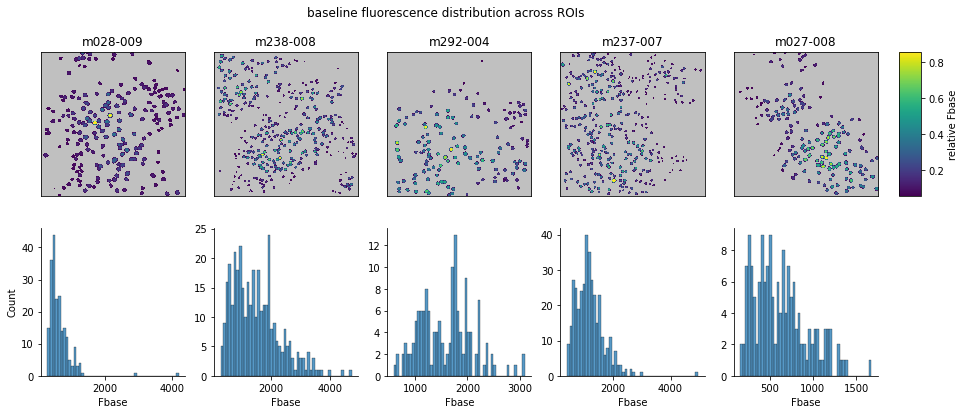

In [8]:
# Plot baseline fluorescence distribution and spatial distribution
fig, axes = plt.subplots(2, len(runs), figsize=(3 * len(runs), 6))
fig.suptitle('baseline fluorescence distribution across ROIs')

Fbasedict = {}
for axcol, (run, F) in zip(axes.T, F_per_run.items()):
    logger.info(f'working on run {run}')

    # Compute baseline fluorescence of each ROI from pre-stimulus interval of original stack
    Fbase = F.loc[pd.IndexSlice['original', framesdict['pre']], :].quantile(0.1, axis=0).iloc[1:]
    Fbase.index = pd.to_numeric(Fbase.index.str.strip('ROI')) - 1
    Fbase.name = 'Fbase'
    Fbase.index.name = 'ROI'
    Fbasedict[run] = Fbase
    
    # Compute relative Fbase
    rel_Fbase = (Fbase - Fbase.min()) / (Fbase.max() - Fbase.min())

    # Plot map of ROIS with color-coded relative Fbase
    ax = axcol[0]
    ax.set_title(run)
    basemask = masks_per_run[run].copy().astype(float)
    for iROI, rel_fb in rel_Fbase.items():
        basemask[basemask == iROI + 1] = rel_fb
    cmap = plt.get_cmap('viridis')
    cmap.set_under('silver')
    vmin, vmax = rel_Fbase.quantile((.05, .995))
    sm = ax.imshow(basemask, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot histrogram distribution of baseline fluorescence
    ax = axcol[1]
    sns.despine(ax=ax)
    sns.histplot(Fbase, bins=50, ax=ax)

# Add colorbar on right hand side of figure
pos = axcol[0].get_position()
cbar_ax = fig.add_axes([0.92, pos.y0, 0.02, pos.height])
fig.colorbar(sm, cax=cbar_ax, label='relative Fbase')

# Remove redundant y-labels
for ax in axes[1, 1:]:
    ax.set_ylabel(None)

figs['Fbase dists'] = fig

### Compute ROI-specific change in dFF baseline between rest and stim periods, across all stacks 

 2025/12/01 20:24:47: working on run m028-009...
 2025/12/01 20:24:53: ROI dFF change distributions:


,count,mean,std,min,25%,50%,75%,max
kind,,,,,,,,
linreg,212.0,0.029178,0.139864,-0.143338,-0.043843,-0.003985,0.069002,1.188625
linreg_nointercept,212.0,0.046377,0.154074,-0.159254,-0.039706,0.018485,0.074866,1.354116
original,212.0,0.198237,0.177977,-0.038482,0.100149,0.166370,0.229698,1.691236


 2025/12/01 20:24:53: working on run m238-008...
 2025/12/01 20:25:01: ROI dFF change distributions:


,count,mean,std,min,25%,50%,75%,max
kind,,,,,,,,
linreg,360.0,0.051187,0.193905,-0.232295,-0.076179,0.002343,0.122048,1.045261
linreg_nointercept,360.0,0.098765,0.261012,-0.309845,-0.065385,0.034139,0.179558,1.447798
original,360.0,0.281568,0.298135,-0.130995,0.090380,0.206346,0.384389,1.644472


 2025/12/01 20:25:01: working on run m292-004...
 2025/12/01 20:25:06: ROI dFF change distributions:


,count,mean,std,min,25%,50%,75%,max
kind,,,,,,,,
linreg,147.0,0.002626,0.092641,-0.132531,-0.072999,-0.025854,0.076927,0.229126
linreg_nointercept,147.0,-0.000602,0.099122,-0.138348,-0.080707,-0.036769,0.080654,0.240147
original,147.0,0.198147,0.122219,0.021658,0.098285,0.163523,0.290829,0.505466


 2025/12/01 20:25:06: working on run m237-007...
 2025/12/01 20:25:13: ROI dFF change distributions:


,count,mean,std,min,25%,50%,75%,max
kind,,,,,,,,
linreg,367.0,0.020465,0.168015,-0.175474,-0.063968,-0.016774,0.076070,2.469634
linreg_nointercept,367.0,0.025688,0.183044,-0.206136,-0.061654,-0.011556,0.081760,2.697512
original,367.0,0.298729,0.236625,-0.020919,0.181665,0.247708,0.368997,3.667473


 2025/12/01 20:25:13: working on run m027-008...
 2025/12/01 20:25:19: ROI dFF change distributions:


,count,mean,std,min,25%,50%,75%,max
kind,,,,,,,,
linreg,158.0,0.017652,0.087989,-0.151363,-0.038429,0.004314,0.054915,0.381784
linreg_nointercept,158.0,0.035327,0.096089,-0.113099,-0.036466,0.011974,0.082473,0.392051
original,158.0,0.218292,0.117218,0.022769,0.129863,0.194472,0.280034,0.620632


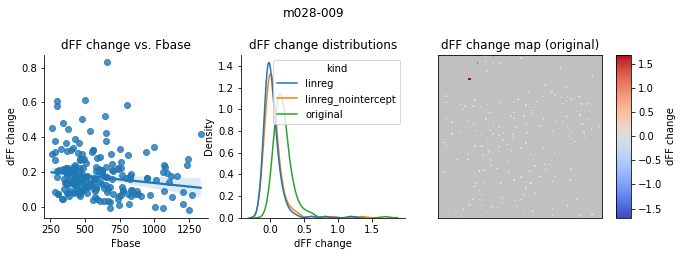

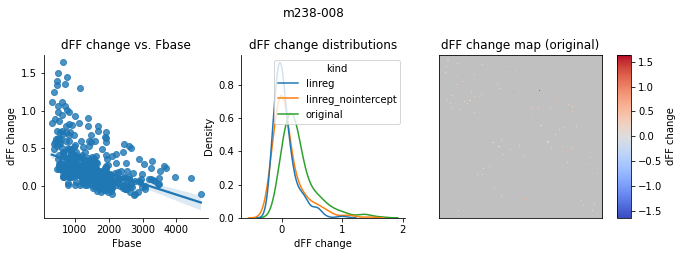

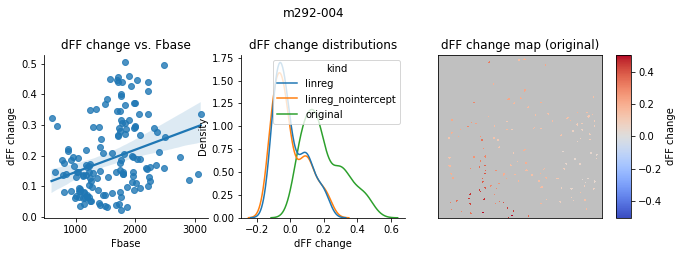

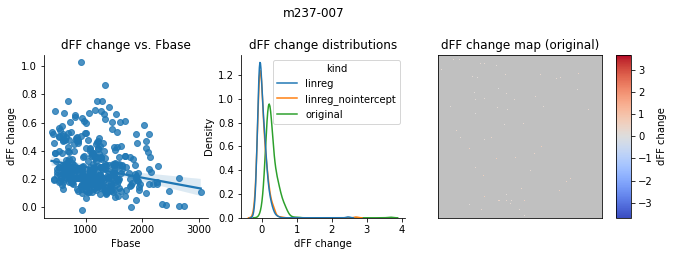

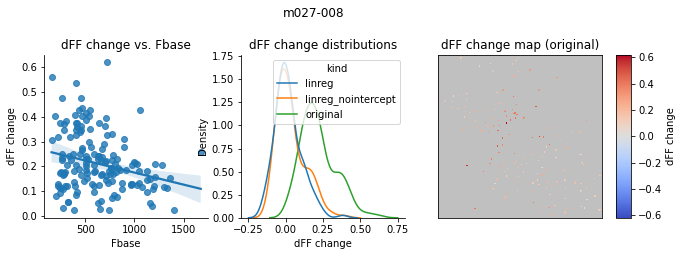

In [9]:
# Loop through runs
ROI_dFF_change_per_run = {}
for run, dFF in dFF_per_run.items():
    logger.info(f'working on run {run}...')

    # Split traces into pre, stim and post intervals
    dFF_split = {k: dFF.loc[pd.IndexSlice[:, v], :] for k, v in framesdict.items()}

    # Compute baseline dFF values for each ROI and interval
    dFF_refs = {
        k: v.groupby('kind').agg(lambda x: x.quantile(.1)) 
        for k, v in dFF_split.items()
    }

    # Compute dFF change as difference between stim and no-stim values
    ROI_dFF_change = (dFF_refs['stim'] - dFF_refs['nostim']).iloc[:, 1:]
    ROI_dFF_change.columns = pd.to_numeric(ROI_dFF_change.columns.str.strip('ROI')) - 1
    ROI_dFF_change.columns.name = 'ROI'
    ROI_dFF_change = ROI_dFF_change.stack().rename('dFF change')
    ROI_dFF_change_per_run[run] = ROI_dFF_change

    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    fig.suptitle(run, y=1.1)

    # Merge baseline fluorescence and dFF change dataframes, and remove outliers
    df = pd.concat([Fbasedict[run], ROI_dFF_change.loc['original']], axis=1)
    df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]

    # Plot dFF change as a function of baseline fluorescence
    ax = axes[0]
    sns.despine(ax=ax)
    ax.set_title('dFF change vs. Fbase')
    sns.regplot(
        ax=ax,
        data=df,
        x='Fbase',
        y='dFF change',
        robust=True,
    )

    # Plot distribution of dFF baseline change during stim, across corrections
    ax = axes[1]
    sns.despine(ax=ax)
    ax.set_title('dFF change distributions')
    sns.kdeplot(
        ax=ax,
        data=ROI_dFF_change.reset_index(), 
        x='dFF change', 
        hue='kind',
        fill=False,
    )

    # Plot dFF change spatial distribution from original stack
    ax = axes[2]
    ax.set_title('dFF change map (original)')
    dFFchange_mask = masks_per_run[run].copy().astype(float)
    dFFchange_mask[dFFchange_mask == 0.] = np.nan
    for iROI, dFFc in ROI_dFF_change.loc['original'].items():
        dFFchange_mask[dFFchange_mask == iROI + 1] = dFFc
    cmap = plt.get_cmap('coolwarm')
    cmap.set_bad('silver')
    absvmax = np.nanmax(np.abs(dFFchange_mask))
    sm = ax.imshow(dFFchange_mask, cmap=cmap, vmin=-absvmax, vmax=absvmax)
    ax.set_xticks([])
    ax.set_yticks([])
    pos = ax.get_position()
    cbar_ax = fig.add_axes([0.92, pos.y0, 0.02, pos.height])
    fig.colorbar(sm, cax=cbar_ax, label='dFF change')
    figs['dFF change dists'] = fig

    # Describe ROI dFF change distributions
    logger.info('ROI dFF change distributions:')
    display(ROI_dFF_change.groupby('kind').describe())

### Plot comparative traces for FOV average and a few random ROIs, across stacks

 2025/12/01 20:25:20: working on run m028-009
 2025/12/01 20:25:21: plotting dFF % traces for columns ['FOV', 'ROIavg']
 2025/12/01 20:25:21: plotting dFF % traces for columns ['FOV', 'ROI81', 'ROI44', 'ROI32']
 2025/12/01 20:25:21: plotting dFF % traces for columns ['FOV', 'ROI182', 'ROI56', 'ROI58']
 2025/12/01 20:25:21: plotting dFF % traces for columns ['FOV', 'ROI17', 'ROI212', 'ROI12']
 2025/12/01 20:25:21: working on run m238-008
 2025/12/01 20:25:21: plotting dFF % traces for columns ['FOV', 'ROIavg']
 2025/12/01 20:25:21: plotting dFF % traces for columns ['FOV', 'ROI252', 'ROI183', 'ROI213']
 2025/12/01 20:25:22: plotting dFF % traces for columns ['FOV', 'ROI136', 'ROI346', 'ROI352']
 2025/12/01 20:25:22: plotting dFF % traces for columns ['FOV', 'ROI129', 'ROI185', 'ROI218']
 2025/12/01 20:25:22: working on run m292-004
 2025/12/01 20:25:22: plotting dFF % traces for columns ['FOV', 'ROIavg']
 2025/12/01 20:25:22: plotting dFF % traces for columns ['FOV', 'ROI18', 'ROI68', '

/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/seaborn/axisgrid.py:1274: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


 2025/12/01 20:25:24: plotting dFF % traces for columns ['FOV', 'ROIavg']
 2025/12/01 20:25:24: plotting dFF % traces for columns ['FOV', 'ROI116', 'ROI101', 'ROI57']
 2025/12/01 20:25:24: plotting dFF % traces for columns ['FOV', 'ROI77', 'ROI38', 'ROI55']
 2025/12/01 20:25:24: plotting dFF % traces for columns ['FOV', 'ROI4', 'ROI9', 'ROI7']


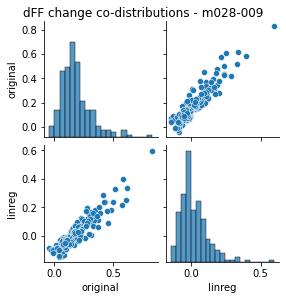

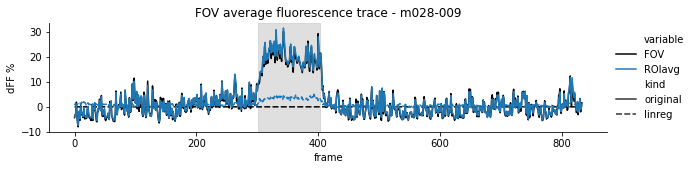

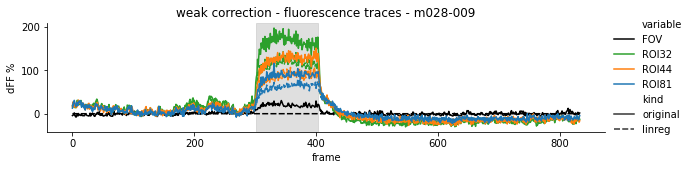

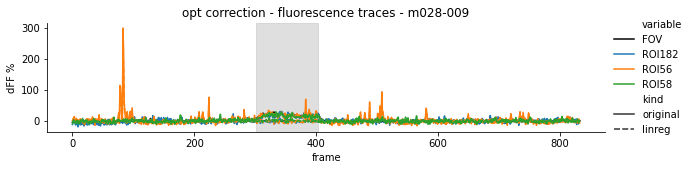

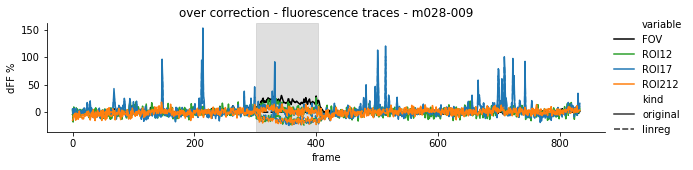

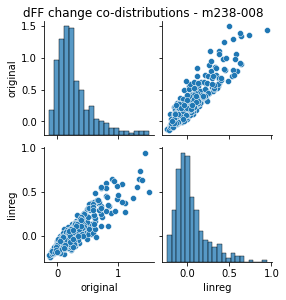

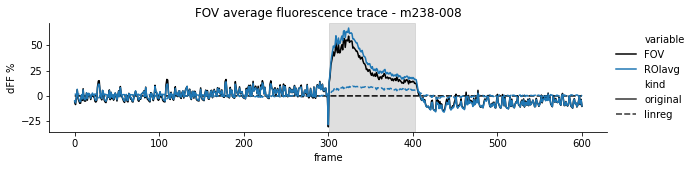

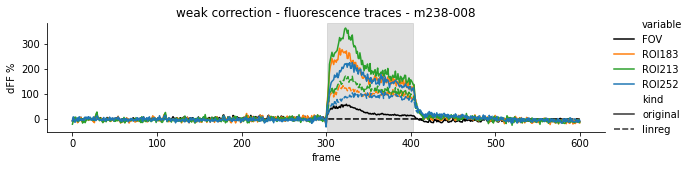

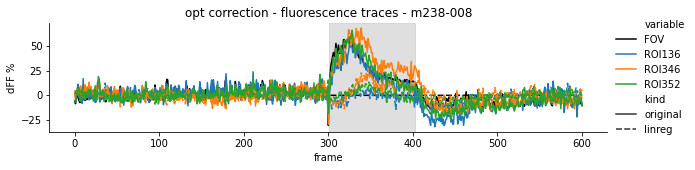

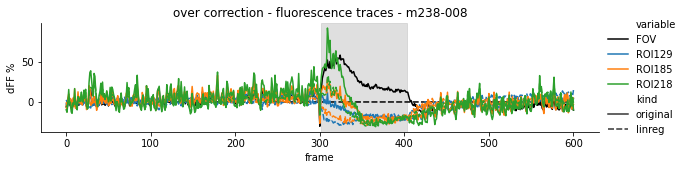

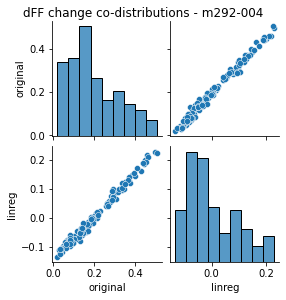

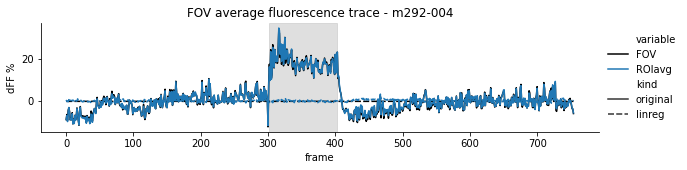

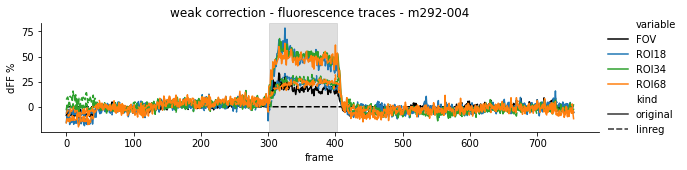

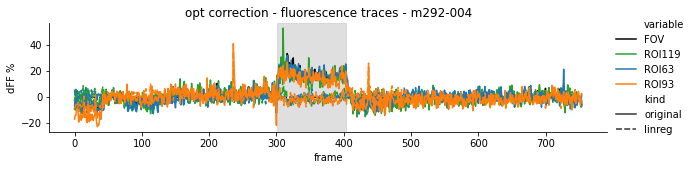

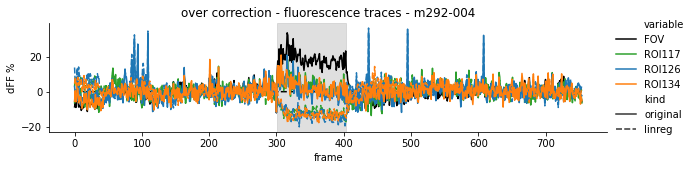

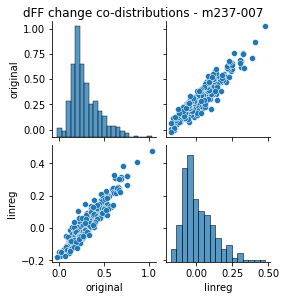

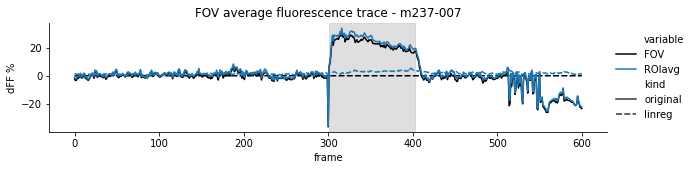

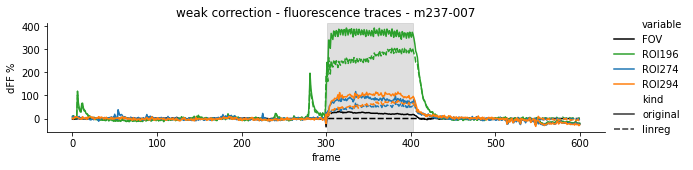

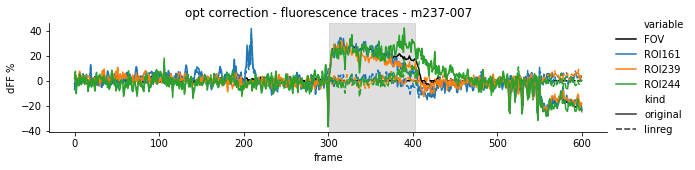

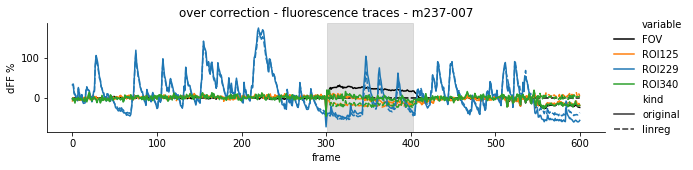

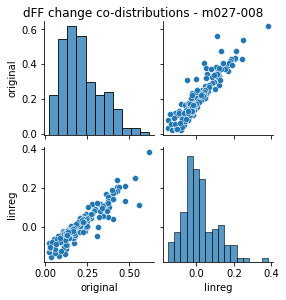

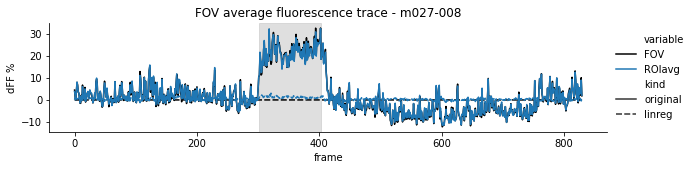

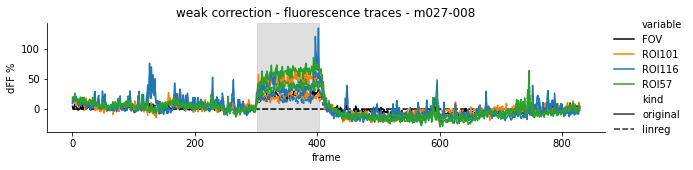

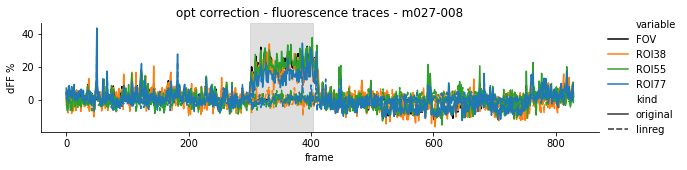

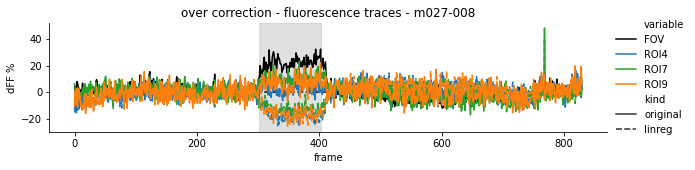

In [10]:
for run, dFF in dFF_per_run.items():

    logger.info(f'working on run {run}')
    # Assemble traces dictionary
    traces_dict = {
        # 'F': F, 
        'dFF %': dFF * 100
    }

    # Define reference correction key
    refcorrkey = 'linreg'
    traces_dict = {
        k: v[v.index.get_level_values('kind').isin(('original', refcorrkey))] 
        for k, v in traces_dict.items()
    }

    # Extract ROI dFF change for that run
    ROI_dFF_change = ROI_dFF_change_per_run[run]

    # Sort ROIs by dFF change, for each stack
    sorted_ROI_dFF_change = ROI_dFF_change.groupby('kind').apply(lambda x: x.sort_values().droplevel(0))
    iROIs_by_change = {k: v.droplevel(0).index.values for k, v in sorted_ROI_dFF_change.groupby('kind')}

    # Plot co-distributions of dFF change for original and reference corrected stacks
    df = ROI_dFF_change.unstack().T[['original', refcorrkey]]
    df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]
    g = sns.pairplot(df, height=2)
    fig = g.figure
    fig.suptitle(f'dFF change co-distributions - {run}', y=1.02)
    figs[f'dFF change pairplot {run}'] = fig

    # Gather indexes of ROIs for which correction is too weak, optimal or too strong
    nROIs_plt = 3
    iROIs_dict = {
        'weak': sorted_ROI_dFF_change.loc[refcorrkey].tail(nROIs_plt).index.values,
        'opt': sorted_ROI_dFF_change.loc[refcorrkey].abs().sort_values().head(nROIs_plt).index.values,
        'over': sorted_ROI_dFF_change.loc[refcorrkey].head(nROIs_plt).index.values,
    }

    fig = plot_traces(
        traces_dict,
        istimbounds=istimbounds,
        ROIavg=True,
    )
    fig.axes[0].set_title(f'FOV average fluorescence trace - {run}');
    figs[f'avg trace {run}'] = fig

    # Plot F and dFF traces
    for k, iROIs in iROIs_dict.items():
        fig = plot_traces(
            traces_dict,
            iROIs=iROIs,
            istimbounds=istimbounds,
        )
        fig.axes[0].set_title(f'{k} correction - fluorescence traces - {run}');
        figs[f'{k} traces {run}'] = fig

### Save figures

In [16]:
save_figs_book(figsdir, figs, suffix='optoconstrict')

 2025/12/01 20:27:28: saving figures in /Users/tlemaire/Documents/data/hemo2p/DVAA datasets/figs/figs_optoconstrict_20251201.pdf:


100%|██████████| 28/28 [00:03<00:00,  7.06it/s]
